In [71]:
x1 = (['a','b','c','d'],[1,2,3,4])
x2 = (['z','x','c','v','c'],[1,12,23,34,45])

In [122]:
for i in range(1000):
    crossover(x1,x2,0.3)

In [105]:
    def crossover(x1, x2, r):
        a1, sl1 = x1
        a2, sl2 = x2
        COa = []
        COsl = []

        for i in range(max(len(a1),len(a2))):
            if i + 1 > len(a1):
                COa.append(a2[i])
                COsl.append(sl2[i])

            elif i + 1 > len(a2):
                COa.append(a1[i])
                COsl.append(sl1[i])

            else:
                if random.random() > r:
                    COa.append(a2[i])
                    COsl.append(sl2[i])
                else:        
                    COa.append(a1[i])
                    COsl.append(sl1[i])
                
        return (COa, COsl)


In [19]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import cv2
import keras
import numpy as np
import random
import time
import warnings
from Util.Cov_Util import extractModelArchitect, buildModelByArtchitect, modelReduction, total_lines, calc_coverage
import tensorflow as tf
import pandas as pd

layer_dict=pd.read_csv('Util/layer_dict.csv', index_col=0)

class Cov_GA:
    def __init__(self, model_architecture, seedlist, x):
        #population: list of (model_architecture, hyperparamters seed list)
        assert len(model_architecture) == len(seedlist), 'layer not matching seed length'
        self.P = []
        
        self.source_architect = model_architecture
        self.source_seedlist = seedlist
        self.source_model_coverage = None
        
        if len(x.shape) == 3:
            self.input = x[None,:]
        else: self.input = x
        
        self.fit_hist = []
        self.fail_P = []
        
    # initialzie model architecture list
    def initPopulation(self, n):
        self.n = n        
        self.P.append((self.source_architect, self.source_seedlist))        
        self.source_model_coverage = calc_coverage(self.source_architect, self.source_seedlist, self.input)
                
        for _ in range(n-1):
            print(f'Initializaing population: {_+2}/{n}')
            #mutate
            mutate_seedlist = []
            for seed in self.source_seedlist:
                noise = np.array([_ for _ in np.random.standard_cauchy(len(seed))], dtype=int)
                mutate_seedlist.append((seed + noise).tolist())
            self.P.append((self.source_architect, mutate_seedlist))
        print()
        
        return 

    # compute fitness scores for populations
    def computeFitness(self):
        Fit = []
        count = 1
        for p in (self.P):
            print(f'Computing Fitness: {count}/{len(self.P)}')
            count+=1
            try:
                Fit.append(total_lines(calc_coverage(p[0], p[1], self.input)))
            except:
                Fit.append(0)
                self.fail_P.append(p)
                print('Fail to compute fitess')
            
        return Fit

    # select m candidates for parents of next-generation inputs
    def select(self, m, Fit, file=None):
        selected_index = np.argpartition(Fit, -m)[-m:]
        P_prime = [self.P[_] for _ in selected_index]
        if file!=None:
            file.write(f'{P_prime}, ')
            file.write(f'{[Fit[_] for _ in selected_index]}\n')
    
        return P_prime

    # select 2 parents from the candidates
    def selectParents(self, P_prime):
        x1, x2 = random.sample(list(P_prime), 2)
        return x1, x2

    # return a flatten list of a crossover product of the selected parents
    def crossover(self, x1, x2, r):
        a1, sl1 = x1
        a2, sl2 = x2
        COa = []
        COsl = []

        for i in range(max(len(a1),len(a2))):
            if i > len(a1):
                COa.append(a2[i])
                COsl.append(sl2[i])

            elif i > len(a2):
                COa.append(a1[i])
                COsl.append(sl1[i])

            elif random.random() > r:
                COa.append(a2[i])
                COsl.append(sl2[i])
            else:        
                COa.append(a1[i])
                COsl.append(sl1[i])
                
        return (COa, COsl)

    # mutate the crossover product
    def mutate(self, x_prime):
        architecture = x_prime[0][:]
        seedlist = x_prime[1][:]
        
        #add random layer
        aval_layer = []
        for layer in layer_dict.index.tolist():
            if layer not in architecture: aval_layer.append(layer)

        if aval_layer:
            newlayer = random.choice(aval_layer)
            newseed = np.ones(layer_dict.loc[newlayer]['para_num'], dtype=int).tolist()

            insert = int(random.random()*len(architecture))

            architecture.insert(insert, newlayer)
            seedlist.insert(insert, newseed)
        
        #mutate hyperparameters
        mutate_seedlist = []
        for seed in seedlist:
            noise = np.array([_ for _ in np.random.standard_cauchy(len(seed))], dtype=int)
            mutate_seedlist.append((seed + noise).tolist())
#         print('print mutated population: ',  architecture, mutate_seedlist)
        return (architecture, mutate_seedlist)



ModuleNotFoundError: No module named 'Util.Cov_Util'; 'Util' is not a package

In [14]:
def cov_ga_main(model_architecture, seedlist, x, m, n, r, maxIter, ga=None):
    sstart_time = time.time()
    
    if ga == None:
        ga = Cov_GA(model_architecture, seedlist, x)
        ga.initPopulation(n)
        
    else:
        print('Continuing from the previous populations...')
        
    prev_iter = len(ga.fit_hist)
    for i in range(prev_iter, prev_iter + maxIter):
        start_time = time.time()
        Fit = ga.computeFitness()
        ga.fit_hist.append(Fit)
        
        if i < prev_iter + maxIter - 1: # no mutation and crossover in the last iteration
            P_prime = ga.select(m, Fit)
            P_pp = []
            P_pp.extend(P_prime)
            while len(P_pp) < n:
                x1, x2 = ga.selectParents(P_prime)
                x_prime = ga.crossover(x1, x2, r)
                #crossover
                x_pp = ga.mutate(x_prime)
                P_pp.append(x_pp)
        ga.P = P_pp
            
        end_time = time.time()
        print('Average fitness value: {}'.format(np.mean(Fit)))
        print('Time taken: {}'.format(end_time - start_time))
        print()
    
    f.close
    print()
    print('Total time taken:', end_time - sstart_time)
    
    return ga

In [15]:
(a, sl) = [(['ReLU', 'LocallyConnected2D', 'SeparableConv2D', 'Conv2DTranspose', 'AveragePooling2D', 'SimpleRNN', 'ZeroPadding2D', 'Conv3DTranspose', 'BatchNormalization', 'Conv2D', 'AveragePooling1D', 'Conv1D', 'GlobalMaxPooling2D', 'GlobalAveragePooling3D', 'GaussianDropout', 'LocallyConnected1D', 'SpatialDropout1D', 'SeparableConv1D', 'ThresholdedReLU', 'Flatten', 'AveragePooling3D', 'MaxPooling2D', 'Conv3D', 'DepthwiseConv2D', 'Dense'], [[-3], [65, 9, 19], [-863, -17, 37, 3], [-1, 17, 0, 6], [7, -7], [7, -38, 9, 63, -7, -15], [915], [-25, -68, 1, -20], [-5, 14], [-44, 43, 33, 30], [-3, 2], [80, -20, -8, 76], [7], [6], [-86], [-3, 1, -54], [9], [-43, 51, 13, 8], [12], [], [-5, -3], [2, -3], [12, 14, 3, -4], [-154, 1, 7], [10]]), (['ReLU', 'LocallyConnected2D', 'SeparableConv2D', 'Conv2DTranspose', 'AveragePooling2D', 'SimpleRNN', 'ZeroPadding2D', 'Conv3DTranspose', 'BatchNormalization', 'Conv2D', 'AveragePooling1D', 'Conv1D', 'GlobalMaxPooling2D', 'GlobalAveragePooling3D', 'GaussianDropout', 'LocallyConnected1D', 'SpatialDropout1D', 'GlobalAveragePooling1D', 'SeparableConv1D', 'ThresholdedReLU', 'Flatten', 'AveragePooling3D', 'MaxPooling2D', 'Conv3D', 'DepthwiseConv2D', 'Dense'], [[-3], [66, 8, 16], [-864, -4, 32, 1], [-2, 17, 0, 5], [6, -7], [7, -40, 12, 63, -6, -14], [915], [-26, -70, 1, -19], [-6, 28], [-40, 43, 33, 30], [-5, 2], [79, -21, -8, 76], [3], [6], [-86], [-3, 0, -55], [9], [1], [-43, 51, 9, -4], [12], [], [-4, -1], [2, -2], [12, 13, 0, 0], [-154, 1, 7], [22]])][1]
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x = x_test[0]

In [16]:
a = ['Conv2D', 'Flatten', 'Dense']
sl = [[0,0,0,0], [], [0]]

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x = x_test[0]

In [17]:
ga = Cov_GA(a, sl, x)
ga.initPopulation(5)

Initializaing population: 2/5
Initializaing population: 3/5
Initializaing population: 4/5
Initializaing population: 5/5



In [18]:
ga_main(a, sl, x, m=2, r=0.3, n=5, maxIter=20, ga=ga)

Continuing from the previous populations...
Running at iteration 1:
Computing Fitness: 1/5
Computing Fitness: 2/5
Computing Fitness: 3/5
Computing Fitness: 4/5
Computing Fitness: 5/5
Average fitness value: 3927.6
Time taken: 112.41229104995728

Running at iteration 2:
Computing Fitness: 1/5
Computing Fitness: 2/5
Computing Fitness: 3/5
Computing Fitness: 4/5
Computing Fitness: 5/5
Average fitness value: 4075.0
Time taken: 112.44976305961609

Running at iteration 3:
Computing Fitness: 1/5
Computing Fitness: 2/5
Computing Fitness: 3/5
Computing Fitness: 4/5
Fail to compute fitess
Computing Fitness: 5/5
Average fitness value: 3548.4
Time taken: 98.96714401245117

Running at iteration 4:
Computing Fitness: 1/5
Computing Fitness: 2/5
Computing Fitness: 3/5
Computing Fitness: 4/5
Computing Fitness: 5/5


IndexError: list index out of range

In [ ]:
ga.fit_hist

Result

In [31]:
import matplotlib.pyplot as plt
import numpy as np


In [42]:
with open('Plot.txt') as f:
    lines = f.readlines()
    
y = []
for i in lines[2:-1]:
    y.append(np.average(eval(i[-13:])))
x=range(len(y))

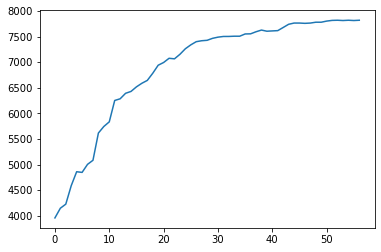

In [44]:
plt.plot(x,y)